# Quickstart Example with Synthetic RTB Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing the logged dataset collected on an RTB environment.

This example on consists of the following 3 cases:
1. Discrete Action Case
2. Continuous Action Case
3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# import SCOPE-RL modules
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.utils import check_random_state

In [2]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# version
print(scope_rl.__version__)

0.1.2


In [4]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 0. Description of Synthetic RTB Simulation Environment
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [7]:
# setup environment
env = RTBEnv(random_state=random_state)

In [8]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicyConfig(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ).create(device=device),
    name="random",
)

In [9]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [10]:
# state consists of the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


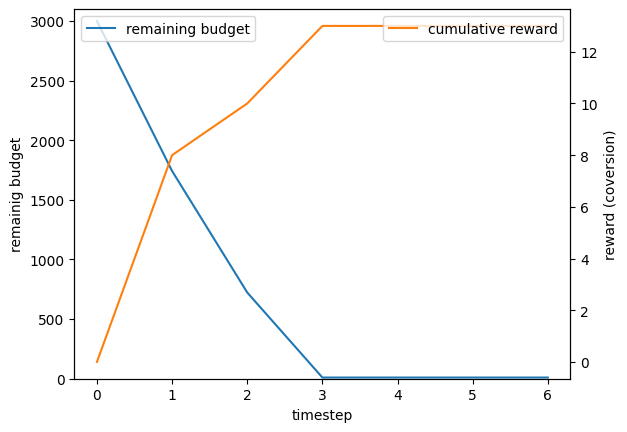

In [11]:
# let's visualize the transition of the remaining budget and cumulative reward
# our goal is to obtain a policy (or an agent) that maximizes the cumulative reward under budget constraints using RL.  
# for more visualization, please see the appendix.
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a behavior policy in the case of discrete action.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [12]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")

In [14]:
# learn a base deterministic policy for data collection
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# replay buffer
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [16]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [17]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 16:49:50 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochastic behavior policy.

We use epsilon-greedy policy to collect logged data using `EpsilonGreedyHead`, where the behavior policy greedily takes an action chosen by the deterministic policy with probability $1 - \epsilon$ and takes an action randomly with probability $\epsilon$ as follows.

$$\pi(a | s) := (1 - \epsilon) * \pi_{\mathrm{det}}(a | s) + \epsilon / |\mathcal{A}|,$$

where $a \in \mathcal{A}$ is an action, $s \in \mathcal{S}$ is a state, and $\pi$ is a stochastic policy defined with the (deterministic) behavior policy $\pi_{\mathrm{det}}$.

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

In [18]:
# convert the base ddqn policy into a stochastic data collection policy
from scope_rl.policy import EpsilonGreedyHead

behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [ ]:
# collect data
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [20]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.15434279e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         9.90049751e-01, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 9.79000000e+02, 5.27965284e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

In [21]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

adjust rate  average bid price  impression         click  \
count  70000.000000       70000.000000  70000.0000  70000.000000   
mean       2.292270         131.269011     75.2031      7.914886   
std        3.103391         158.513015     89.8231      9.930448   
min        0.000012           4.004975      0.0000      0.000000   
25%        0.100000           4.705882      0.0000      0.000000   
50%        0.774264          59.980375      6.0000      0.000000   
75%        2.159631         278.317592    179.0000     17.000000   
max       10.000000         546.900000    290.0000     48.000000   

         conversion  winning rate  click / impression  conversion / click  
count  70000.000000  70000.000000        70000.000000        70000.000000  
mean       2.025843      0.412287            0.055333            0.116279  
std        3.082174      0.439671            0.077373            0.170241  
min        0.000000      0.000000            0.000000            0.000000  
25%        0.000000      0.000000            0.000000            0.000000  
50%        0.000000      0.201856            0.000000            0.000000  
75%        4.000000      0.995327            0.104478            0.217391  
max       20.000000      1.000000            0.999995            0.999998

In [22]:
# aggregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

average adjust rate  average bid price  total impression   total click  \
count         10000.000000       10000.000000      10000.000000  10000.000000   
mean              2.292270         131.269011         75.203100      7.914886   
std               0.945540          52.736378         14.261024      1.462237   
min               0.135120           7.631997          0.285714      0.000000   
25%               1.811682          96.116198         69.000000      7.857143   
50%               2.180416         129.916298         76.857143      8.428571   
75%               2.864227         168.969656         83.714286      8.714286   
max               6.086100         345.044714        119.714286     10.142857   

       total conversion  remaining budget  
count      10000.000000      10000.000000  
mean           2.025843        508.401300  
std            0.629777        636.963511  
min            0.000000          1.000000  
25%            1.571429         21.000000  
50%            2.000000         54.000000  
75%            2.428571       1039.000000  
max            4.857143       3000.000000

In [23]:
# we see a strong correlation between number of impression and click.
# However, large number of click does not necessarily lead to conversion.
sns.pairplot(df_[:100])

### 1.2. Softmax behavior policy
We can also use `SoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of a given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as:

$$\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)},$$

where $A$ indicates the set discrete actions and $\tau$ is an inverse temperature parameter.

In [24]:
# convert base ddqn policy into a stochastic data collection policy
from scope_rl.policy import SoftmaxHead

behavior_policy = SoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [ ]:
# collect data
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [26]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 6.43101135e-01],
        [1.00000000e+00, 3.00000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.78255940e-01],
        [2.00000000e+00, 3.00000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.78255940e-01],
        ...,
        [4.00000000e+00, 1.90500000e+03, 3.65000000e-01, ...,
         1.00000000e+00, 4.00000000e+00, 1.00000000e+0

In [27]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

adjust rate  average bid price    impression         click  \
count  70000.000000       70000.000000  70000.000000  70000.000000   
mean       1.773876          98.360753     68.533957      7.137486   
std        2.532414         135.622399     87.575986      9.531898   
min        0.000165           4.011429      0.000000      0.000000   
25%        0.166810           7.891987      0.000000      0.000000   
50%        0.464159          23.953916      4.000000      0.000000   
75%        2.154435         115.488738    172.000000     16.000000   
max       10.000000         547.265957    276.000000     47.000000   

         conversion  winning rate  click / impression  conversion / click  
count  70000.000000  70000.000000        70000.000000        70000.000000  
mean       1.666314      0.380639            0.056165            0.104472  
std        2.729116      0.428933            0.085250            0.166036  
min        0.000000      0.000000            0.000000            0.000000  
25%        0.000000      0.000000            0.000000            0.000000  
50%        0.000000      0.140983            0.000000            0.000000  
75%        3.000000      0.944746            0.102804            0.187500  
max       20.000000      1.000000            0.999997            0.999998

In [28]:
# aggregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

average adjust rate  average bid price  total impression   total click  \
count         10000.000000       10000.000000      10000.000000  10000.000000   
mean              1.773876          98.360753         68.533957      7.137486   
std               0.976728          52.883208         21.721911      2.210259   
min               0.162882           6.636410          0.000000      0.000000   
25%               0.960473          55.960386         57.000000      5.857143   
50%               1.651326          93.292262         74.142857      8.142857   
75%               2.383959         132.519422         84.000000      8.714286   
max               6.230459         336.219291        121.571429     10.571429   

       total conversion  remaining budget  
count      10000.000000      10000.000000  
mean           1.666314        807.798500  
std            0.732255        860.252136  
min            0.000000          1.000000  
25%            1.142857         29.000000  
50%            1.714286        548.000000  
75%            2.142857       1443.000000  
max            4.285714       3000.000000

In [29]:
# seems softmax policy obtain impression more, but conversion less than the epsilon-greedy policy
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb).

For more advanced topic in OPE and OPS, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb).

## 2. Continuous Action Space
We also describe the case where a continuous behavior policy is used. \
Here, we first learn a base deterministic policy in a similar manner with the discrete action case.

In [31]:
# standardized environment for continuous action
env = gym.make("RTBEnv-continuous-v0")

In [32]:
# learn base deterministic policy for data collection
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# model
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
).create(device=device)

# setup replay buffer
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [35]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2023-07-22 17:04:29 [warning  ] Parameters will be reinitialized.


### 2.1. Gaussian behavior policy

Then, we convert a deterministic policy (i.e., greedy action choice of sac policy) into a stochastic policy. 

As the action space of `RTBEnv` is bounded, we use `TruncatedGaussianHead`. \
Given the deterministic action $\pi(s)$, this behavior policy samples actions from a truncated gaussian distribution as:

$$a \sim Truncnorm(\pi(s), \sigma),$$

where $\sigma$ indicates the noise level. 

Note that, when action space is not bounded, we can use `GaussianHead` in a similar manner.

In [35]:
# convert base ddqn policy into a stochastic data collection policy
from scope_rl.policy import TruncatedGaussianHead

behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # lower bound of the action space
    maximum=env.action_space.high,  # upper bound of the action space
    sigma=np.array([1.0]),  # noise level of a gaussian distribution
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [ ]:
# collect data
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [37]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 7.38851424e-01],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 5.41722533e+00],
        [2.00000000e+00, 1.17300000e+03, 3.85863874e-01, ...,
         1.00000000e+00, 1.00000000e+00, 9.04188838e+00],
        ...,
        [4.00000000e+00, 2.20000000e+01, 0.00000000e+00, ...,
         3.38164251e-02, 0.00000000e+00, 9.91771869e+00],
        [5.00000000e+00, 2.20000000e+01, 0.00000000e+00, ...,
         4.92610837e-03, 0.00000000e+00, 7.81845410e+00],
        [6.00000

In [38]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse, similarly to the discrete case
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

adjust rate  average bid price    impression         click  \
count  70000.000000       70000.000000  70000.000000  70000.000000   
mean       6.592979         382.843519     91.830129      8.580243   
std        3.113360         100.143291     90.748515      9.548014   
min        0.000027           4.901478      0.000000      0.000000   
25%        4.488277         342.836634      6.000000      0.000000   
50%        8.009422         412.295648     34.000000      2.000000   
75%        9.108331         448.845318    190.000000     18.000000   
max       10.300053         548.952381    290.000000     41.000000   

         conversion  winning rate  click / impression  conversion / click  
count  70000.000000  70000.000000        70000.000000        70000.000000  
mean       2.053800      0.526100            0.055684            0.125776  
std        3.030225      0.432456            0.062548            0.180461  
min        0.000000      0.000000            0.000000            0.000000  
25%        0.000000      0.050251            0.000000            0.000000  
50%        0.000000      0.547117            0.062500            0.000000  
75%        3.000000      1.000000            0.099502            0.214286  
max       20.000000      1.000000            0.999995            0.999998

In [39]:
# aggregate episodic statistics
# compared to the discrete case, remaining budget is small, meaning that the continuous case is more flexible
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

average adjust rate  average bid price  total impression   total click  \
count         10000.000000       10000.000000      10000.000000  10000.000000   
mean              6.592979         382.843519         91.830129      8.580243   
std               0.602869          30.625998         10.732850      0.357118   
min               3.745769         248.655743         53.142857      7.285714   
25%               6.203521         363.019623         84.571429      8.285714   
50%               6.643230         385.472716         91.142857      8.571429   
75%               7.038746         405.814897         98.571429      8.857143   
max               8.311466         456.525261        133.000000     10.000000   

       total conversion  remaining budget  
count      10000.000000       10000.00000  
mean           2.053800          17.44850  
std            0.482136          12.07078  
min            0.428571           1.00000  
25%            1.714286           7.00000  
50%            2.000000          16.00000  
75%            2.428571          25.00000  
max            4.142857          85.00000

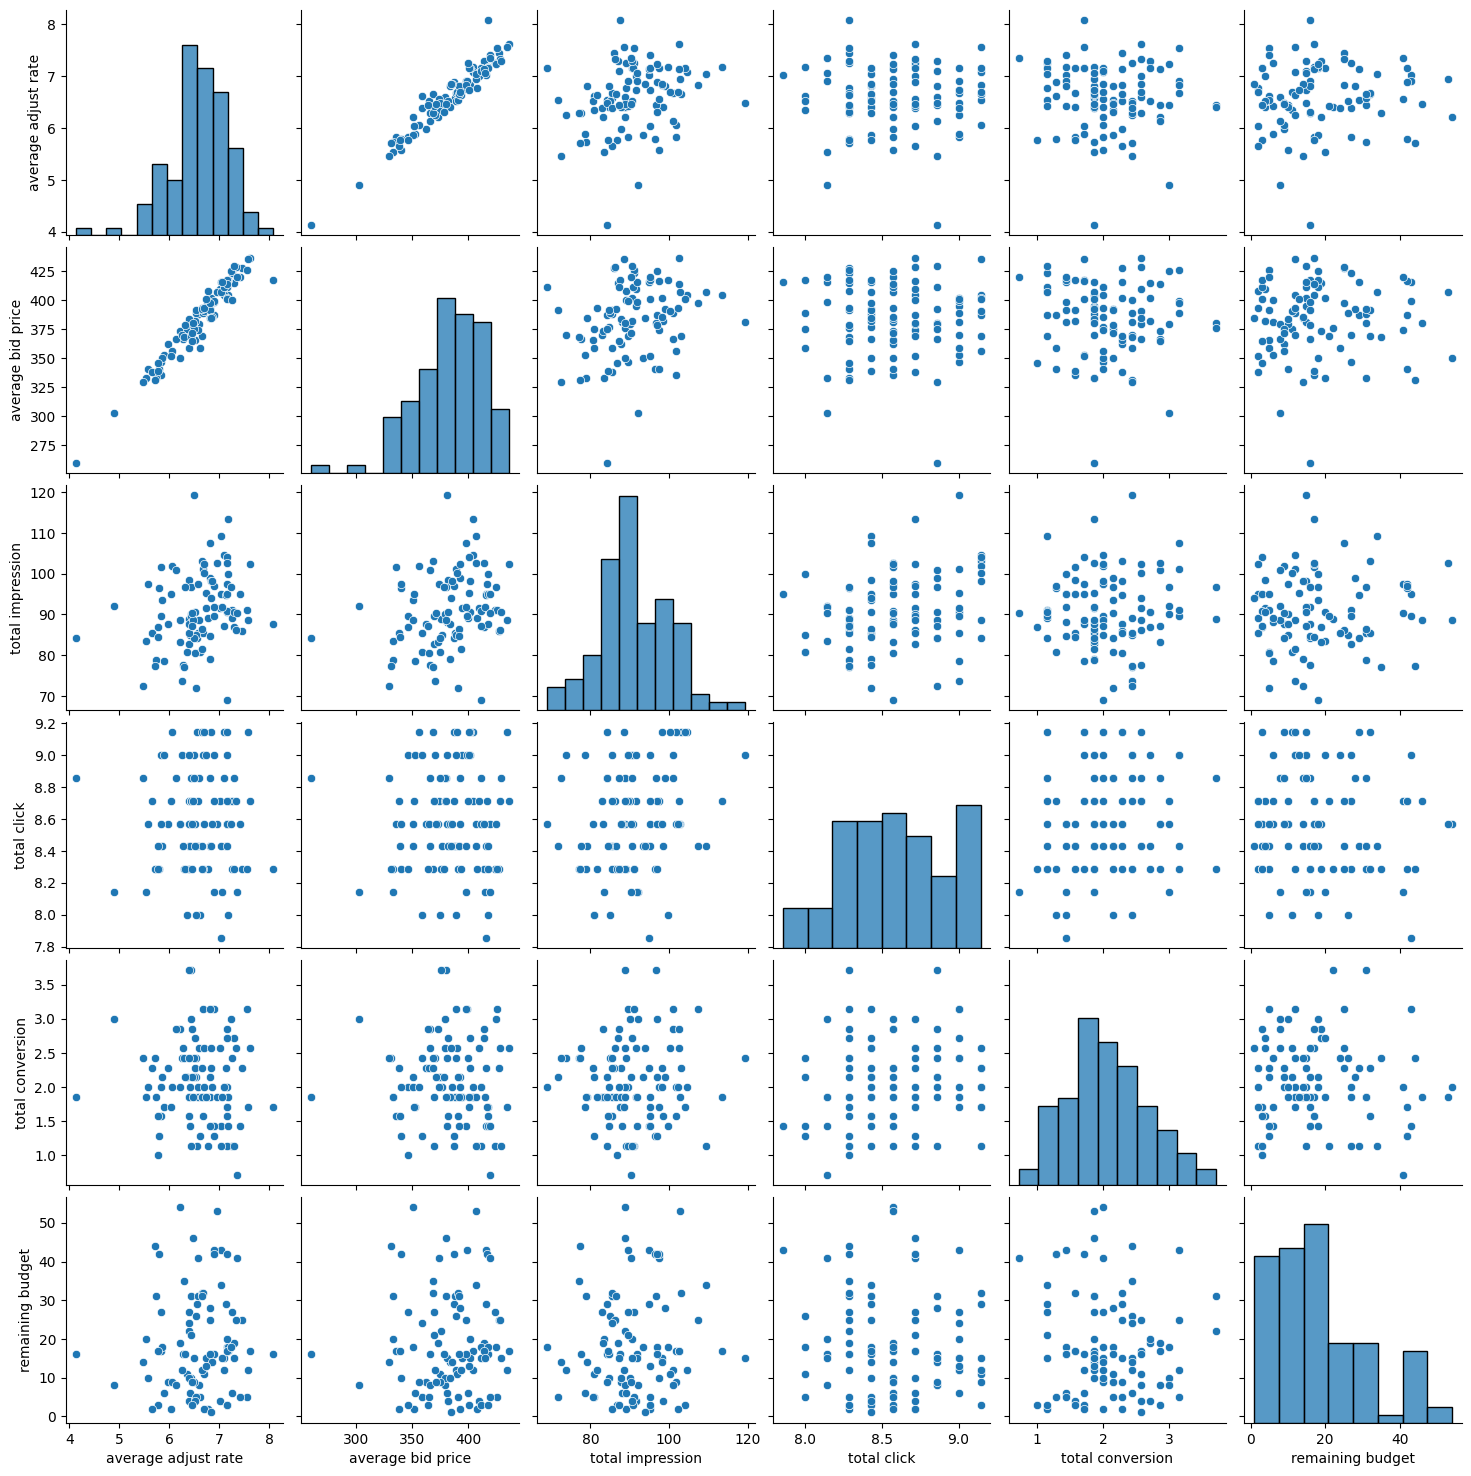

In [40]:
# the result reveals that there is slight negative correlation between bid price and impression
sns.pairplot(df_[:100])

## 3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds
Finally, we show how to collect logged data by several behavior policies and random seeds.

We show the example in the discrete action case, but the continuous action case can also be handled in a simmilar manner.

In [41]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")

In [42]:
# define several behavior policies
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,  # probability of taking random action
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,  # probability of taking random action
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,  # probability of taking random action
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [43]:
# initialize the dataset class
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [ ]:
logged_datasets = dataset.obtain_episodes(
    behavior_policies=behavior_policies,
    n_datasets=2,  # number of random states
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [45]:
logged_dataset = logged_datasets.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.87517002e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e-01],
        ...,
        [4.00000000e+00, 9.79000000e+02, 5.27965284e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_basic.ipynb). 

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.